Imports

In [1]:
import json
import os
import random
import numpy as np
import torch as tr
from datetime import datetime
import pandas as pd
import shutil
import pickle

import torch.nn as nn
from sincfold.dataset import SeqDataset, pad_batch
from torch.utils.data import DataLoader
from sincfold.model import sincfold, SincFold
from sincfold.embeddings import NT_DICT
from sincfold.utils import write_ct, validate_file, ct2dot
from sincfold.parser import parser
from sincfold.utils import dot2png, ct2svg

# Parser e hiperparametros, semilla

In [2]:

# args = parser()

# if not args.no_cache and args.command == "train":
#     cache_path = "cache/"
# else:
#     cache_path = None

# config= {"device": args.d, "batch_size": args.batch, 
#             "valid_split": 0.1, "max_len": args.max_length, "verbose": not args.quiet, "cache_path": cache_path}

# if "max_epochs" in args:
#     config["max_epochs"] = args.max_epochs

# if args.config is not None:
#     config.update(json.load(open(args.config)))

# if config["cache_path"] is not None:
#     shutil.rmtree(config["cache_path"], ignore_errors=True)
#     os.makedirs(config["cache_path"])

# # Reproducibility
# tr.manual_seed(42)
# random.seed(42)
# np.random.seed(42)

# if args.command == "train": 
#     train(args.train_file, config, args.out_path,  args.valid_file, args.j)

# if args.command == "test":
#     test(args.test_file, args.model_weights, args.out_path, config, args.j)

# if args.command == "pred":
#     pred(args.pred_file, model_weights=args.model_weights, out_path=args.out_path, logits=args.logits, config=config, nworkers=args.j, draw=args.draw, draw_resolution=args.draw_resolution)    

In [3]:

# Reproducibility
tr.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Original network

# Train

In [4]:
# Train Params
train_file ='../data/ArchiveII_sample.csv'
config={}
out_path=None
valid_file=None
nworkers=2
verbose=True

In [ ]:
if out_path is None:
    out_path = f"results_{str(datetime.today()).replace(' ', '-')}/"
else:
    out_path = out_path

if verbose:
    print("Working on", out_path)

if "cache_path" not in config:
    config["cache_path"] = "cache/"

if not os.path.isdir(out_path):
    os.makedirs(out_path)
else:
    raise ValueError(f"Output path {out_path} already exists")

if valid_file is not None:
    train_file = train_file
    valid_file = valid_file
else:
    data = pd.read_csv(train_file)
    valid_split = config["valid_split"] if "valid_split" in config else 0.1
    train_file = os.path.join(out_path, "train.csv")
    valid_file = os.path.join(out_path, "valid.csv")

    val_data = data.sample(frac = valid_split)
    val_data.to_csv(valid_file, index=False)
    data.drop(val_data.index).to_csv(train_file, index=False)
    
batch_size = config["batch_size"] if "batch_size" in config else 4
train_loader = DataLoader(
    SeqDataset(train_file, training=True, **config),
    batch_size=batch_size, 
    shuffle=True,
    num_workers=nworkers,
    collate_fn=pad_batch
)
valid_loader = DataLoader(
    SeqDataset(valid_file, **config),
    batch_size=batch_size,
    shuffle=False,
    num_workers=nworkers,
    collate_fn=pad_batch,
)

net = sincfold(train_len=len(train_loader), **config)

best_f1, patience_counter = -1, 0
patience = config["patience"] if "patience" in config else 30
if verbose:
    print("Start training...")
max_epochs = config["max_epochs"] if "max_epochs" in config else 1000
logfile = os.path.join(out_path, "train_log.csv") 
    
for epoch in range(max_epochs):
    train_metrics = net.fit(train_loader)

    val_metrics = net.test(valid_loader)

    if val_metrics["f1"] > best_f1:
        best_f1 = val_metrics["f1"]
        tr.save(net.state_dict(), os.path.join(out_path, "weights.pmt"))
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter > patience:
            break
    
    if not os.path.exists(logfile):
        with open(logfile, "w") as f: 
            msg = ','.join(['epoch']+[f"train_{k}" for k in sorted(train_metrics.keys())]+[f"valid_{k}" for k in sorted(val_metrics.keys())]) + "\n"
            f.write(msg)
            f.flush()
            if verbose:
                print(msg)

    with open(logfile, "a") as f: 
        msg = ','.join([str(epoch)]+[f'{train_metrics[k]:.4f}' for k in sorted(train_metrics.keys())]+[f'{val_metrics[k]:.4f}' for k in sorted(val_metrics.keys())]) + "\n"
        f.write(msg)
        f.flush()    
        if verbose:
            print(msg)
        
# remove temporal files           
shutil.rmtree(config["cache_path"], ignore_errors=True)

tmp_file = os.path.join(out_path, "train.csv")
if os.path.exists(tmp_file):
    os.remove(tmp_file)
tmp_file = os.path.join(out_path, "valid.csv")
if os.path.exists(tmp_file):
    os.remove(tmp_file)

Working on results_2024-10-07-13:14:06.448821/
No weights provided, using random initialization
Start training...


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


epoch,train_f1,train_loss,valid_f1,valid_f1_post,valid_loss

0,0.0016,0.5476,0.0000,0.0000,0.1929



100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


1,0.0000,0.2032,0.0000,0.0000,0.2465



100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


2,0.0000,0.2356,0.0000,0.0000,0.2406



100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


3,0.0000,0.1556,0.0000,0.0000,0.2045



100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


4,0.0000,0.1079,0.0000,0.0000,0.1705



100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


5,0.0000,0.0802,0.0000,0.0000,0.1437



100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


6,0.0160,0.0896,0.1143,0.1143,0.1232



100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


7,0.1481,0.0546,0.3043,0.3256,0.1092



100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


8,0.1523,0.0535,0.3396,0.3265,0.0962



100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


9,0.2534,0.0710,0.3396,0.3333,0.0880



100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


10,0.2304,0.0446,0.4561,0.4615,0.0848



100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


11,0.1942,0.0462,0.4407,0.4444,0.0833



100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


12,0.2192,0.0399,0.4444,0.4643,0.0815



100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


13,0.2862,0.0528,0.4348,0.4590,0.0804



100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


14,0.2154,0.0416,0.4478,0.4667,0.0813



100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


15,0.2573,0.0429,0.4839,0.4912,0.0848



100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


16,0.2406,0.0556,0.4483,0.4528,0.0887



100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


17,0.2612,0.0531,0.4333,0.4364,0.0866



100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


18,0.2836,0.0400,0.4839,0.4912,0.0829



100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


19,0.2874,0.0529,0.4839,0.4912,0.0819



100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


20,0.2663,0.0367,0.4407,0.4444,0.0859



100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


21,0.2699,0.0363,0.4286,0.4314,0.0939



100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


22,0.3197,0.0361,0.4286,0.4314,0.0928



100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


23,0.3315,0.0468,0.4483,0.4528,0.0831



100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


24,0.3436,0.0411,0.4839,0.4912,0.0774



100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


25,0.4056,0.0397,0.4918,0.5000,0.0772



100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


26,0.3655,0.0413,0.5000,0.5091,0.0795



100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


27,0.3788,0.0429,0.4828,0.4615,0.0806



100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


28,0.3213,0.0318,0.4561,0.4314,0.0814



100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


29,0.3396,0.0304,0.4643,0.4400,0.0800



100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


30,0.4100,0.0347,0.4828,0.4615,0.0771



100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


31,0.4402,0.0332,0.5246,0.5091,0.0733



100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


32,0.4425,0.0344,0.5000,0.4815,0.0741



100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


33,0.4936,0.0359,0.4912,0.4615,0.0777



100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


34,0.4634,0.0348,0.4828,0.4615,0.0759



100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


35,0.4841,0.0284,0.4918,0.4727,0.0735



100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


36,0.4298,0.0300,0.4727,0.4314,0.0823



100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


37,0.5123,0.0301,0.4727,0.4314,0.0823



100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


38,0.5727,0.0278,0.5000,0.4727,0.0738



100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


39,0.3874,0.0270,0.5085,0.4815,0.0747



100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


40,0.5303,0.0290,0.4727,0.4314,0.0771



100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


41,0.4860,0.0266,0.4912,0.4528,0.0724



100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


42,0.6201,0.0246,0.5397,0.4912,0.0684



100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


43,0.5322,0.0243,0.5667,0.5091,0.0708



100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


44,0.4854,0.0226,0.4906,0.4400,0.0770



100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


45,0.4866,0.0241,0.5000,0.4898,0.0827



100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


46,0.6128,0.0236,0.5763,0.5455,0.0710



100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


47,0.6578,0.0208,0.5484,0.5357,0.0665



100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


48,0.5943,0.0234,0.4815,0.4706,0.0760



100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


49,0.6044,0.0211,0.4800,0.5106,0.0853



100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


50,0.5791,0.0204,0.5862,0.5818,0.0688



100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


51,0.4923,0.0199,0.4800,0.5106,0.0948



100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


52,0.6004,0.0212,0.4167,0.4444,0.1019



100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


53,0.5664,0.0203,0.5862,0.6182,0.0701



100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


54,0.5035,0.0192,0.5574,0.6071,0.0646



100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


55,0.5403,0.0174,0.4800,0.5106,0.0794



100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


56,0.6898,0.0181,0.4800,0.5106,0.0802



100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


57,0.7128,0.0176,0.5862,0.6182,0.0707



 33%|███▎      | 1/3 [04:14<08:29, 254.57s/it]

[]

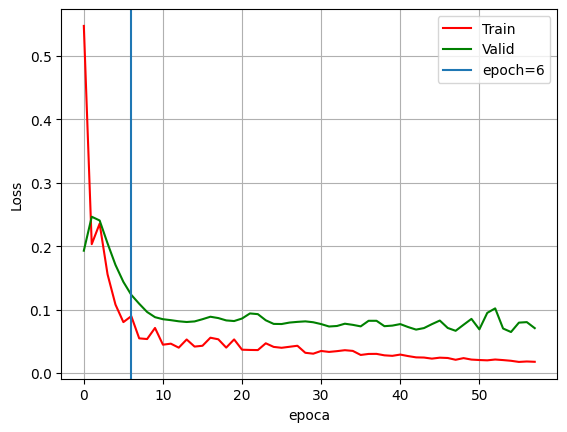

In [12]:
import matplotlib.pyplot as plt

df_log = pd.read_csv('./results_2024-10-07-13:14:06.448821/train_log.csv')
df_log.head(1)

fig, ax = plt.subplots()
ax.plot(df_log.epoch, df_log.train_loss, color='red', label='Train')
ax.plot(df_log.epoch, df_log.valid_loss, color='green', label='Valid')
ax.grid()
ax.axvline(x=6, label='epoch=6')
ax.set_xlabel('epoca')
ax.set_ylabel('Loss')
plt.legend()
plt.plot()

## Test 

In [23]:
# Test Parameters: FIXED
test_file = '../data/ArchiveII_sample.csv'
model_weights=None
output_file=None
config={}
nworkers=2
verbose=True

In [11]:
# LOAD the test dataset
test_file = test_file
test_file = validate_file(test_file)
if verbose not in config:
    config["verbose"] = verbose

test_loader = DataLoader(
    SeqDataset(test_file, **config),
    batch_size=config["batch_size"] if "batch_size" in config else 4,
    shuffle=False,
    num_workers=nworkers,
    collate_fn=pad_batch,
)

if model_weights is not None:
    net = sincfold(weights=model_weights, **config)
else:
    net = sincfold(pretrained=True, **config)

Load pretrained weights...


In [12]:
net

SincFold(
  (resnet1d): Sequential(
    (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,), padding=same)
    (1): ResidualLayer1D(
      (layer): Sequential(
        (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=same, dilation=(3,))
        (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv1d(16, 32, kernel_size=(1,), stride=(1,), padding=same)
      )
    )
    (2): ResidualLayer1D(
      (layer): Sequential(
        (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=same, dilation=(3,))
        (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv1d(16, 32, kernel_size=(1,), stride=(1,), padding=same)
  

In [13]:
if verbose:
    print(f"Start test of {test_file}")        
test_metrics = net.test(test_loader)
summary = ",".join([k for k in sorted(test_metrics.keys())]) + "\n" + ",".join([f"{test_metrics[k]:.3f}" for k in sorted(test_metrics.keys())])+ "\n" 
if output_file is not None:
    with open(output_file, "w") as f:
        f.write(summary)
if verbose:
    print(summary)


Start test of ../data/ArchiveII_sample.csv


100%|██████████| 3/3 [02:19<00:00, 46.46s/it]

f1,f1_post,loss
0.944,0.950,0.005



# Crear y probar la calse AblationNet

In [14]:
# Defino las clases de las capas residuales
class ResidualLayer1D(nn.Module):
    def __init__(
        self,
        dilation,
        resnet_bottleneck_factor,
        filters,
        kernel_size,
    ):
        super().__init__()

        num_bottleneck_units = math.floor(resnet_bottleneck_factor * filters)

        self.layer = nn.Sequential(
            nn.BatchNorm1d(filters),
            nn.ReLU(),
            nn.Conv1d(
                filters,
                num_bottleneck_units,
                kernel_size,
                dilation=dilation,
                padding="same",
            ),
            nn.BatchNorm1d(num_bottleneck_units),
            nn.ReLU(),
            nn.Conv1d(num_bottleneck_units, filters, kernel_size=1, padding="same"),
        )

    def forward(self, x):
        return x + self.layer(x)

class ResidualBlock2D(nn.Module):
    def __init__(self, filters, filters1, kernel_size, dilation):
        super().__init__()
        self.layer = nn.Sequential(
            nn.BatchNorm2d(filters),
            nn.ReLU(),
            nn.Conv2d(filters, filters1, kernel_size, padding="same"),
            nn.BatchNorm2d(filters1),
            nn.ReLU(),
            nn.Conv2d(
                filters1, filters, kernel_size, dilation=dilation, padding="same"
            ),
        )

    def forward(self, x):
        return self.layer(x) + x

In [15]:
net.state_dict().keys()

odict_keys(['resnet1d.0.weight', 'resnet1d.0.bias', 'resnet1d.1.layer.0.weight', 'resnet1d.1.layer.0.bias', 'resnet1d.1.layer.0.running_mean', 'resnet1d.1.layer.0.running_var', 'resnet1d.1.layer.0.num_batches_tracked', 'resnet1d.1.layer.2.weight', 'resnet1d.1.layer.2.bias', 'resnet1d.1.layer.3.weight', 'resnet1d.1.layer.3.bias', 'resnet1d.1.layer.3.running_mean', 'resnet1d.1.layer.3.running_var', 'resnet1d.1.layer.3.num_batches_tracked', 'resnet1d.1.layer.5.weight', 'resnet1d.1.layer.5.bias', 'resnet1d.2.layer.0.weight', 'resnet1d.2.layer.0.bias', 'resnet1d.2.layer.0.running_mean', 'resnet1d.2.layer.0.running_var', 'resnet1d.2.layer.0.num_batches_tracked', 'resnet1d.2.layer.2.weight', 'resnet1d.2.layer.2.bias', 'resnet1d.2.layer.3.weight', 'resnet1d.2.layer.3.bias', 'resnet1d.2.layer.3.running_mean', 'resnet1d.2.layer.3.running_var', 'resnet1d.2.layer.3.num_batches_tracked', 'resnet1d.2.layer.5.weight', 'resnet1d.2.layer.5.bias', 'convrank1.weight', 'convrank1.bias', 'convrank2.weight'

In [21]:
state_dict_keys = ['resnet1d.0.weight',
                    'resnet1d.0.bias', 
                    'resnet1d.1.layer.0.weight', 
                    'resnet1d.1.layer.0.bias', 
                    'resnet1d.1.layer.0.running_mean', 
                    'resnet1d.1.layer.0.running_var', 
                    'resnet1d.1.layer.0.num_batches_tracked', 
                    'resnet1d.1.layer.2.weight', 
                    'resnet1d.1.layer.2.bias', 
                    'resnet1d.1.layer.3.weight', 
                    'resnet1d.1.layer.3.bias', 
                    'resnet1d.1.layer.3.running_mean', 
                    'resnet1d.1.layer.3.running_var', 
                    'resnet1d.1.layer.3.num_batches_tracked', 
                    'resnet1d.1.layer.5.weight', 
                    'resnet1d.1.layer.5.bias', 
                    'resnet1d.2.layer.0.weight', 
                    'resnet1d.2.layer.0.bias', 
                    'resnet1d.2.layer.0.running_mean', 
                    'resnet1d.2.layer.0.running_var', 
                    'resnet1d.2.layer.0.num_batches_tracked', 
                    'resnet1d.2.layer.2.weight', 
                    'resnet1d.2.layer.2.bias', 
                    'resnet1d.2.layer.3.weight', 
                    'resnet1d.2.layer.3.bias', 
                    'resnet1d.2.layer.3.running_mean', 
                    'resnet1d.2.layer.3.running_var', 
                    'resnet1d.2.layer.3.num_batches_tracked', 
                    'resnet1d.2.layer.5.weight', 
                    'resnet1d.2.layer.5.bias', 
                    'convrank1.weight', 
                    'convrank1.bias', 
                    'convrank2.weight', 
                    'convrank2.bias', 
                    'resnet2d.0.weight', 
                    'resnet2d.0.bias', 
                    'resnet2d.1.layer.0.weight', 
                    'resnet2d.1.layer.0.bias', 
                    'resnet2d.1.layer.0.running_mean', 
                    'resnet2d.1.layer.0.running_var', 
                    'resnet2d.1.layer.0.num_batches_tracked', 
                    'resnet2d.1.layer.2.weight', 
                    'resnet2d.1.layer.2.bias', 
                    'resnet2d.1.layer.3.weight', 
                    'resnet2d.1.layer.3.bias', 
                    'resnet2d.1.layer.3.running_mean', 
                    'resnet2d.1.layer.3.running_var', 
                    'resnet2d.1.layer.3.num_batches_tracked', 
                    'resnet2d.1.layer.5.weight', 
                    'resnet2d.1.layer.5.bias', 
                    'resnet2d.2.layer.0.weight', 
                    'resnet2d.2.layer.0.bias', 
                    'resnet2d.2.layer.0.running_mean', 
                    'resnet2d.2.layer.0.running_var', 
                    'resnet2d.2.layer.0.num_batches_tracked', 
                    'resnet2d.2.layer.2.weight', 
                    'resnet2d.2.layer.2.bias', 
                    'resnet2d.2.layer.3.weight', 
                    'resnet2d.2.layer.3.bias', 
                    'resnet2d.2.layer.3.running_mean', 
                    'resnet2d.2.layer.3.running_var', 
                    'resnet2d.2.layer.3.num_batches_tracked', 
                    'resnet2d.2.layer.5.weight', 
                    'resnet2d.2.layer.5.bias', 
                    'conv2Dout.weight', 
                    'conv2Dout.bias']

In [17]:
# Clase AblationNet heredando de SincFold
class AblationNet(SincFold):
    def __init__(self, original_net, layers_to_remove):
        super(AblationNet, self).__init__(**original_net.config)  
        self.load_state_dict(original_net.state_dict())        
        self.layers_to_remove = layers_to_remove

    def forward(self, batch):
        x = batch["embedding"].to(self.device)
        batch_size = x.shape[0]
        L = x.shape[2]
        
        
        # y = self.resnet1d(x)
        # ya = self.convrank1(y)
        # ya = tr.transpose(ya, -1, -2)

        ya = self.convrank1(x)
        
        ya = tr.transpose(ya, -1, -2)
        yb = self.convrank2(x)

        y = ya @ yb
        yt = tr.transpose(y, -1, -2)
        y = (y + yt) / 2

        y0 = y.view(-1, L, L) 

        if self.interaction_prior != "none":
            prob_mat = batch["interaction_prior"].to(self.device)
            x1 = tr.zeros([batch_size, 2, L, L]).to(self.device)
            x1[:, 0, :, :] = y0
            x1[:, 1, :, :] = prob_mat
        else:
            x1 = y0.unsqueeze(1)
        
        y = self.resnet2d(x1)

        # if 'resnet2d' not in self.layers_to_remove:
        #     y = self.resnet2d(x1)
        # else:
        #     y = x1

        # output
        y = self.conv2Dout(tr.relu(y)).squeeze(1)
        if batch["canonical_mask"] is not None:
            y = y.multiply(batch["canonical_mask"].to(self.device))
        yt = tr.transpose(y, -1, -2)
        y = (y + yt) / 2

        return y, y0 


layers_to_remove = ['resnet2d']  
ablated_net = AblationNet(net, layers_to_remove)

In [18]:
ablated_net

AblationNet(
  (resnet1d): Sequential(
    (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,), padding=same)
    (1): ResidualLayer1D(
      (layer): Sequential(
        (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=same, dilation=(3,))
        (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv1d(16, 32, kernel_size=(1,), stride=(1,), padding=same)
      )
    )
    (2): ResidualLayer1D(
      (layer): Sequential(
        (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=same, dilation=(3,))
        (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv1d(16, 32, kernel_size=(1,), stride=(1,), padding=same)

## TEST

In [19]:
if verbose:
    print(f"Start test of {test_file}")        
test_metrics = ablated_net.test(test_loader)
summary = ",".join([k for k in sorted(test_metrics.keys())]) + "\n" + ",".join([f"{test_metrics[k]:.3f}" for k in sorted(test_metrics.keys())])+ "\n" 
if output_file is not None:
    with open(output_file, "w") as f:
        f.write(summary)
if verbose:
    print(summary)


Start test of ../data/ArchiveII_sample.csv


  0%|          | 0/3 [00:02<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 32, 3], expected input[4, 4, 356] to have 32 channels, but got 4 channels instead